In [1]:
import os
import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import predictor

np.random.seed(5981)

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

In [2]:
prefix = r'D:\git\zhongguoyuyan\csv\dialect'
location = pd.read_csv(os.path.join(prefix, 'location.csv'), index_col=0)
china = gpd.read_file(r'D:\git\GeoMapData_CN\china.json')
location = gpd.GeoDataFrame(
    location,
    geometry=gpd.points_from_xy(location['longitude'], location['latitude'])
)
location = location.sample(100)

char = pd.read_csv(r'D:\git\zhongguoyuyan\csv\words.csv', index_col=0)
char = char.sample(200)

data = predictor.load_data(prefix, location.index)
data = data[data['iid'].astype(int).isin(char.index)]

D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:311: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['initial'].fillna('').str.lower() \
D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:335: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['finals'].fillna('').str.lower().str.replace(f'[^{ipa}]', '')
D:\git\sinetym\scripts\zhongguoyuyan\predictor.py:347: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = data['tone'].fillna('').str.lower().str.replace(f'[^1-5]', '')


In [ ]:
code = np.arange(0x0370, 0x03ff, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x1f00, 0x1ffe, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0000, 0x007f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0080, 0x00ff, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0100, 0x017f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0180, 0x024f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x2c60, 0x2c7f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0xa720, 0xa7ff, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0xab30, 0xab6f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x10780, 0x107bf, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x1df00, 0x1df1e, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x1e00, 0x1eff, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0xfb00, 0xfb4f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0xff00, 0xffef, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0250, 0x02af, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x1d00, 0x1d7f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x1d80, 0x1dbf, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x2070, 0x209c, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x02b0, 0x02ff, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))
code = np.arange(0x0300, 0x036f, dtype=np.int32)
display(np.frombuffer(code, dtype=f'U{code.size}'))

In [7]:
emb_size = 20

dp = predictor.DialectPredictor(
    data['oid'].unique(),
    data['iid'].unique(),
    (data['initial'].unique(), data['finals'].unique(), data['tone'].unique()),
    emb_size=emb_size,
    target_emb_size=40,
    transform_layer=2,
    transform_size=100,
    activation=tf.keras.activations.softmax,
    target_bias=False,
    emb_l2=0,
    l2=0,
    optimizer=tf.keras.optimizers.Adam(0.02)
)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(data[['oid', 'iid', 'initial', 'finals', 'tone']].values).shuffle(2000000).map(lambda x: (x[:2], x[2:]))
train_dataset = dataset.skip(5000)
test_dataset = dataset.take(5000)

In [9]:
output_prefix = os.path.join(
    'tensorboard',
    'predictor',
    datetime.datetime.now().strftime('%Y%m%d%H%M')
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
acc = tf.keras.metrics.Accuracy('acc', dtype=tf.float32)
eval_loss = tf.keras.metrics.Mean('eval_loss', dtype=tf.float32)
eval_acc = tf.keras.metrics.Accuracy('eval_acc', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(
    step=tf.Variable(0),
    dialect_emb=dp.dialect_emb,
    char_emb=dp.char_emb,
    target_embs=dp.target_embs,
    att_weights=dp.att_weights,
    trans_weights=dp.trans_weights,
    optimizer=dp.optimizer
)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(output_prefix, 'checkpoints'), max_to_keep=10)

In [36]:
epochs = 30
batch_size = 100

checkpoint.restore(manager.latest_checkpoint)

while checkpoint.step < epochs:
    for inputs, targets in train_dataset.shuffle(10000).batch(batch_size):
        l, target_ids, pred_ids = dp.update(inputs, targets)
        loss.update_state(l)
        acc.update_state(target_ids, pred_ids)

    for inputs, targets in test_dataset.batch(batch_size):
        l, target_ids, pred_ids = dp.loss(inputs, targets)
        eval_loss.update_state(l)
        eval_acc.update_state(target_ids, pred_ids, target_ids < tf.cast(tf.stack([t.shape[0] for t in dp.targets]), tf.int64))
    
    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('acc', acc.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('eval_loss', eval_loss.result(), step=tf.cast(checkpoint.step, tf.int64))
            tf.summary.scalar('eval_acc', eval_acc.result(), step=tf.cast(checkpoint.step, tf.int64))
            
    loss.reset_states()
    acc.reset_states()
    eval_loss.reset_states()
    eval_acc.reset_states()

    checkpoint.step.assign_add(1)
    manager.save()

In [37]:
steps = []
dialect_embs = []
char_embs = []
dest_embs = []
target_embs = [list() for _ in dp.target_embs]

for ckpt in manager.checkpoints:
    checkpoint.restore(ckpt)
    steps.append(checkpoint.step.numpy())
    dialect_embs.append(dp.dialect_emb.numpy())
    char_embs.append(dp.char_emb.numpy())
    dest_embs.append(dp.transform(dp.get_dialect_emb(data['oid'].values), dp.get_char_emb(data['iid'].values)).numpy())
    for i, e in enumerate(dp.target_embs):
        target_embs[i].append(e.numpy())
    
steps = np.stack(steps)
dialect_embs = np.stack(dialect_embs)
char_embs = np.stack(char_embs)
dest_embs = np.stack(dest_embs)
target_embs = [np.stack(e) for e in target_embs]

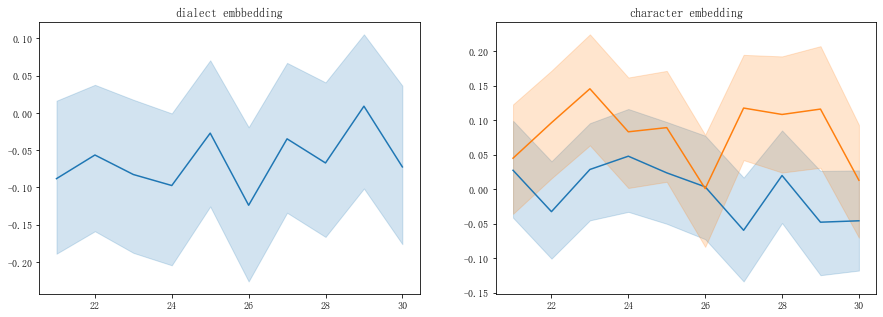

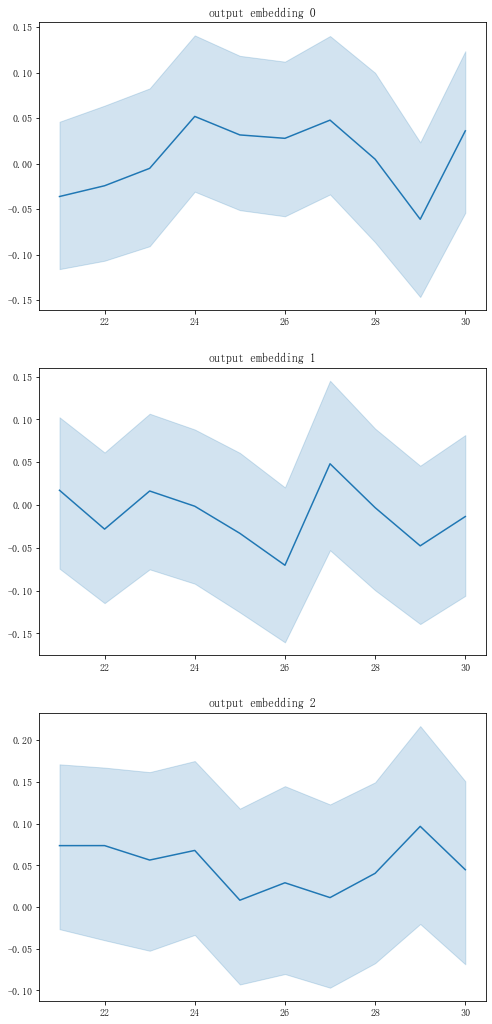

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

x = np.repeat(steps, dialect_embs.shape[1] * dialect_embs.shape[2])
y = dialect_embs.flatten()
if x.shape[0] > 10000:
    idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
    x = x[idx]
    y = y[idx]
    
sns.lineplot(x=x, y=y, ax=ax1)
ax1.set_title('dialect embbedding')

x = np.repeat(steps, char_embs.shape[1] * char_embs.shape[2])
y = char_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)

x = np.repeat(steps, dest_embs.shape[1] * dest_embs.shape[2])
y = dest_embs.flatten()
idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
sns.lineplot(x=x[idx], y=y[idx], ax=ax2)
ax2.set_title('character embedding')

plt.show()

fig, axes = plt.subplots(len(target_embs), 1, squeeze=False)
fig.set_size_inches(8, 6 * len(target_embs))

for i, emb in enumerate(target_embs):
    x = np.repeat(steps, emb.shape[1] * emb.shape[2])
    y = emb.flatten()
    if x.shape[0] > 10000:
        idx = np.random.choice(np.arange(x.shape[0]), 10000, replace=False)
        x = x[idx]
        y = y[idx]
        
    sns.lineplot(x=x, y=y, ax=axes[i, 0])
    axes[i, 0].set_title('output embedding {}'.format(i))
    
plt.show()

In [39]:
dialect_emb = dp.dialect_emb.numpy()
dialect_pca = PCA(2).fit(dialect_emb)
dialect_pc = dialect_pc = dialect_pca.transform(dialect_emb)
char_emb = dp.char_emb.numpy()
char_pca = PCA(2).fit(char_emb)
char_pc = char_pca.transform(char_emb)

initial_emb = dp.target_embs[0].numpy()
final_emb = dp.target_embs[1].numpy()
tone_emb = dp.target_embs[2].numpy()
initial_pc = char_pca.transform(initial_emb[:, :emb_size])
final_pc = char_pca.transform(final_emb[:, :emb_size])
tone_pc = char_pca.transform(tone_emb[:, :emb_size])
initial_dialect_pc = dialect_pca.transform(initial_emb[:, emb_size:])
final_dialect_pc = dialect_pca.transform(final_emb[:, emb_size:])
tone_dialect_pc = dialect_pca.transform(tone_emb[:, emb_size:])

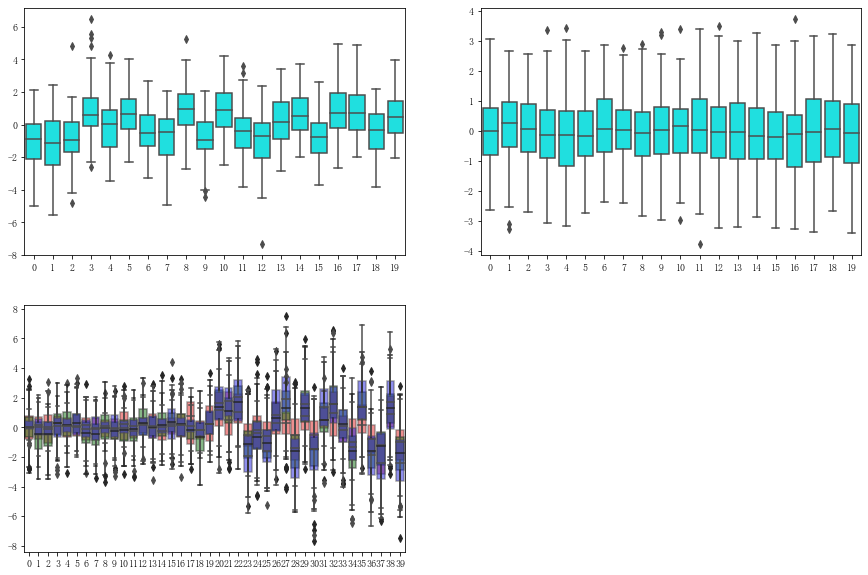

In [40]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(data=dialect_emb, color='cyan')
plt.subplot(2, 2, 2)
sns.boxplot(data=char_emb, color='cyan')
plt.subplot(2, 2, 3)
sns.boxplot(data=initial_emb, color='red', boxprops={'alpha': 0.5})
sns.boxplot(data=final_emb, color='green', boxprops={'alpha': 0.5})
sns.boxplot(data=tone_emb, color='blue', boxprops={'alpha': 0.5})
plt.show()

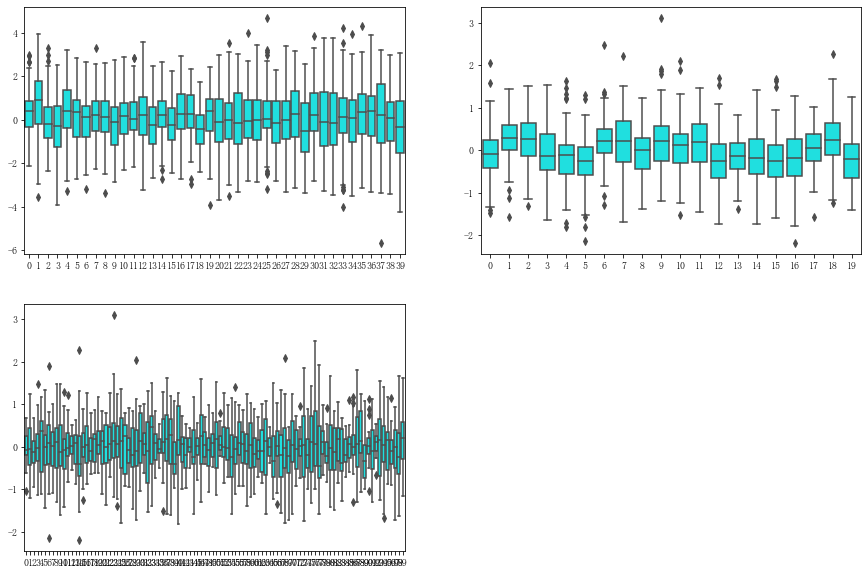

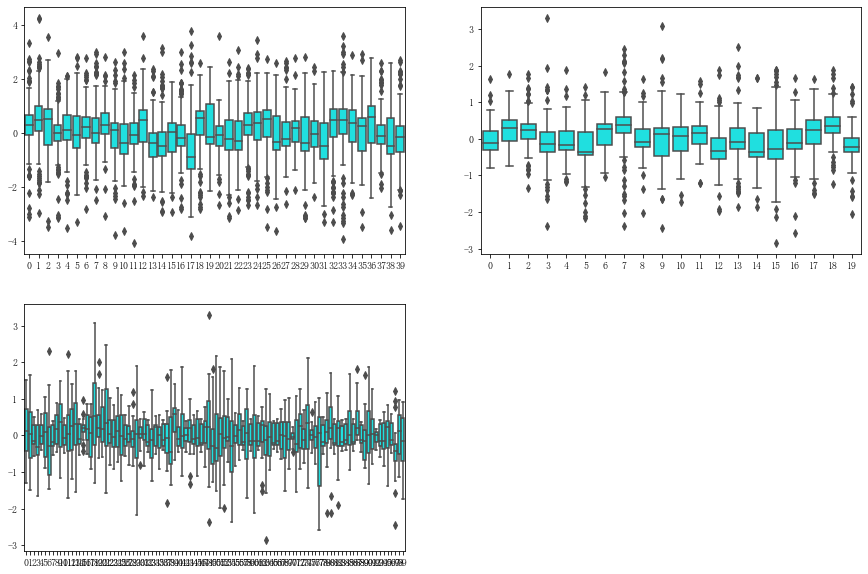

In [41]:
for aw, tw in zip(dp.att_weights, dp.trans_weights):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=aw.numpy().T, color='cyan')
    plt.subplot(2, 2, 2)
    sns.boxplot(data=tw.numpy(), color='cyan')
    plt.subplot(2, 2, 3)
    sns.boxplot(data=tw.numpy().T, color='cyan')
    plt.show()

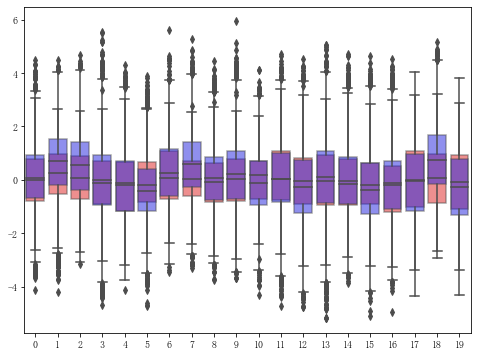

In [42]:
sample_data = data.sample(10000)
dest_emb = dp.transform(dp.get_dialect_emb(sample_data['oid'].values), dp.get_char_emb(sample_data['iid'].values))

plt.figure(figsize=(8, 6))
sns.boxplot(data=char_emb, color='red', boxprops={'alpha': 0.5})
sns.boxplot(data=dest_emb, color='blue', boxprops={'alpha': 0.5})
plt.show()

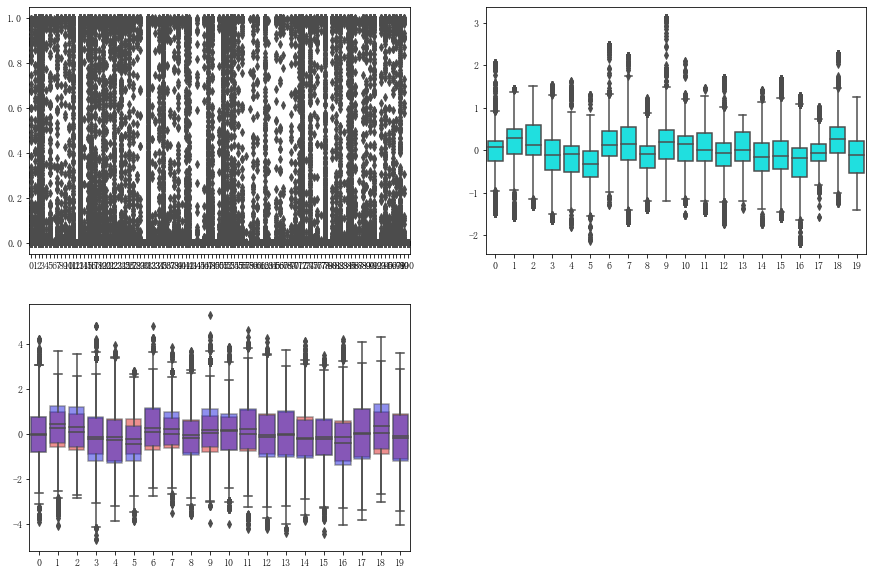

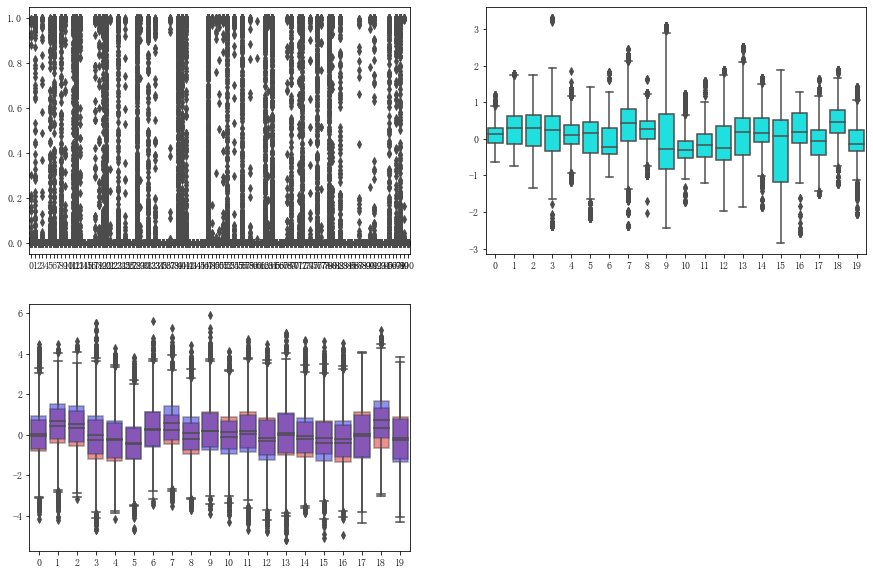

In [43]:
input_dialect_emb = dp.get_dialect_emb(sample_data['oid'])
emb = dp.get_char_emb(sample_data['iid'])
for aw, tw in zip(dp.att_weights, dp.trans_weights):
    att = dp.activation(tf.matmul(tf.concat([input_dialect_emb, emb], axis=1), aw))
    trans = tf.matmul(att[:, :-1], tw)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=att.numpy(), color='cyan')
    plt.subplot(2, 2, 2)
    sns.boxplot(data=trans.numpy(), color='cyan')
    plt.subplot(2, 2, 3)
    sns.boxplot(data=emb.numpy(), color='red', boxprops={'alpha': 0.5})
    emb += trans
    sns.boxplot(data=emb.numpy(), color='blue', boxprops={'alpha': 0.5})
    plt.show()

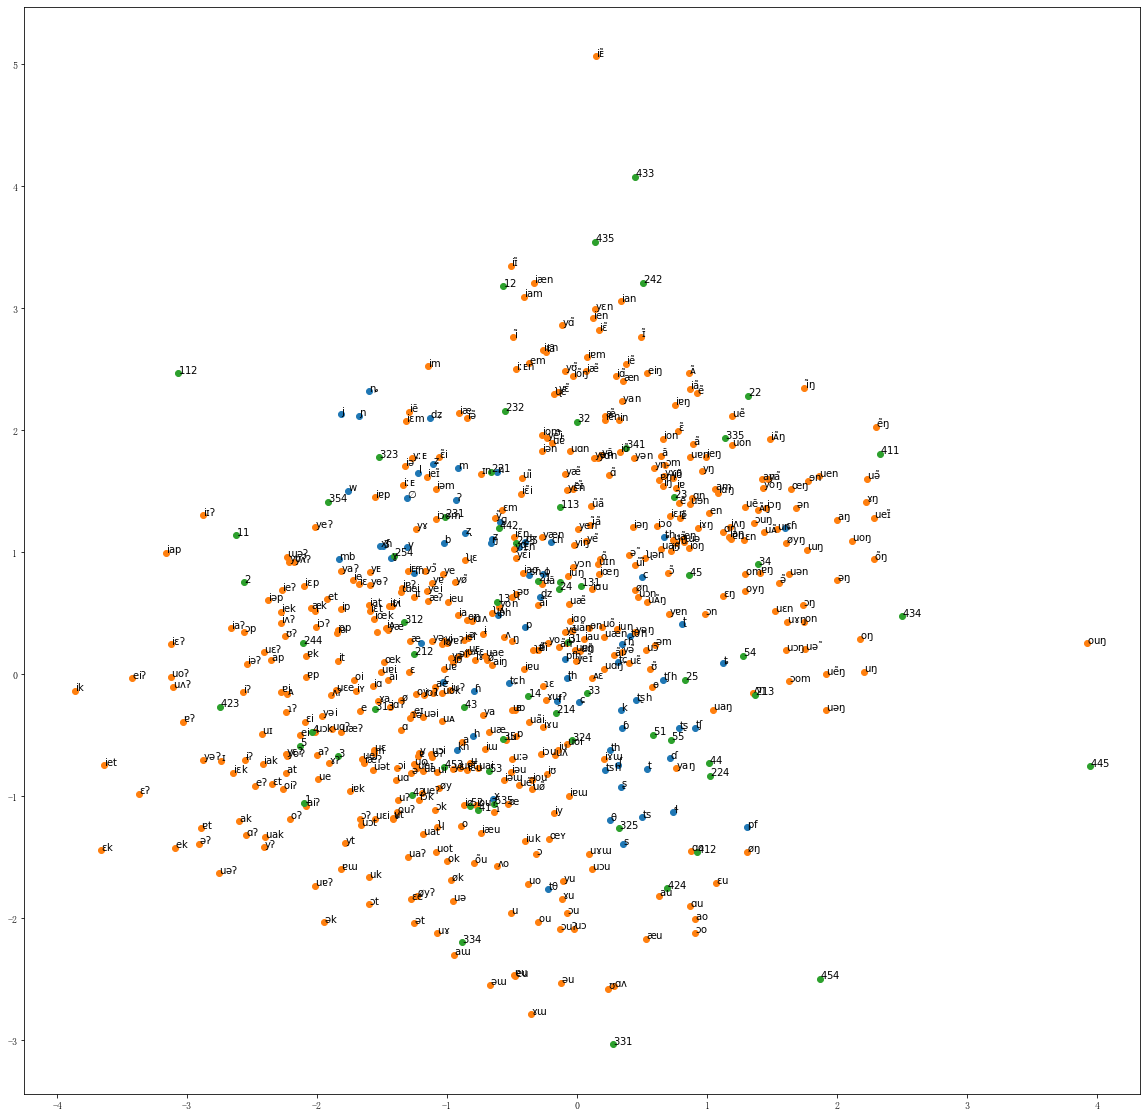

In [44]:
plt.figure(figsize=(20, 20))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(final_pc[:, 0], final_pc[:, 1])
for i, final in enumerate(np.char.decode(dp.targets[1].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(final), xy=(final_pc[i, 0], final_pc[i, 1]))
    
plt.scatter(tone_pc[:, 0], tone_pc[:, 1])
for i, tone in enumerate(np.char.decode(dp.targets[2].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(tone), xy=(tone_pc[i, 0], tone_pc[i, 1]))
    
plt.show()

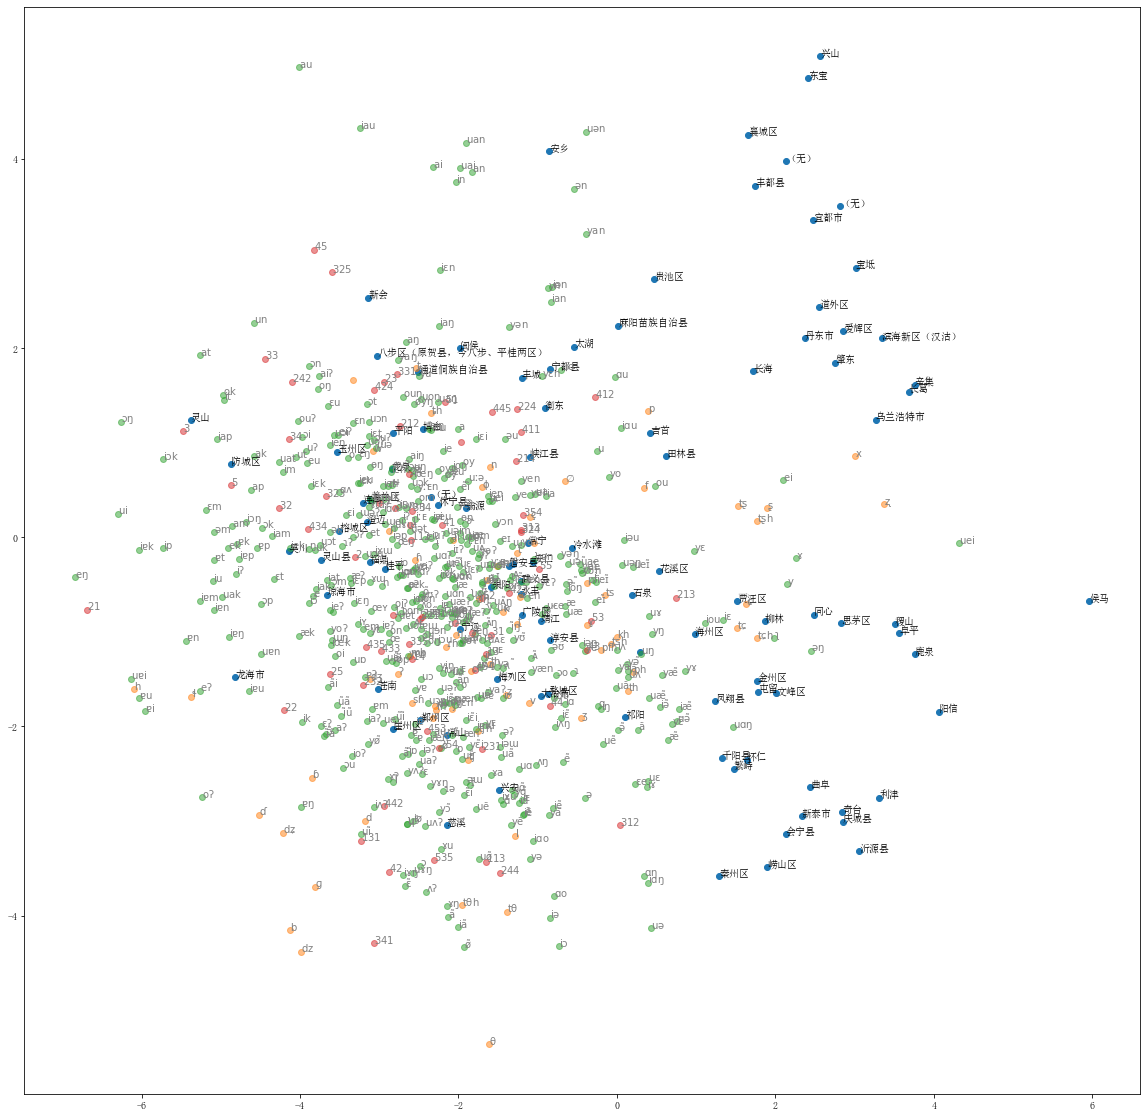

In [45]:
plt.figure(figsize=(20, 20))

dialects = location.loc[np.char.decode(dp.dialects[:-1].numpy().astype(np.bytes_)), 'country'].values
plt.scatter(dialect_pc[:, 0], dialect_pc[:, 1])
for i, dialect in enumerate(dialects):
    plt.annotate(dialect, xy=(dialect_pc[i, 0], dialect_pc[i, 1]))

plt.scatter(initial_dialect_pc[:, 0], initial_dialect_pc[:, 1], alpha=0.5)
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_dialect_pc[i, 0], initial_dialect_pc[i, 1]), color='gray')
    
plt.scatter(final_dialect_pc[:, 0], final_dialect_pc[:, 1], alpha=0.5)
for i, final in enumerate(np.char.decode(dp.targets[1].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(final), xy=(final_dialect_pc[i, 0], final_dialect_pc[i, 1]), color='gray')
    
plt.scatter(tone_dialect_pc[:, 0], tone_dialect_pc[:, 1], alpha=0.5)
for i, tone in enumerate(np.char.decode(dp.targets[2].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(tone), xy=(tone_dialect_pc[i, 0], tone_dialect_pc[i, 1]), color='gray')
    
plt.show()

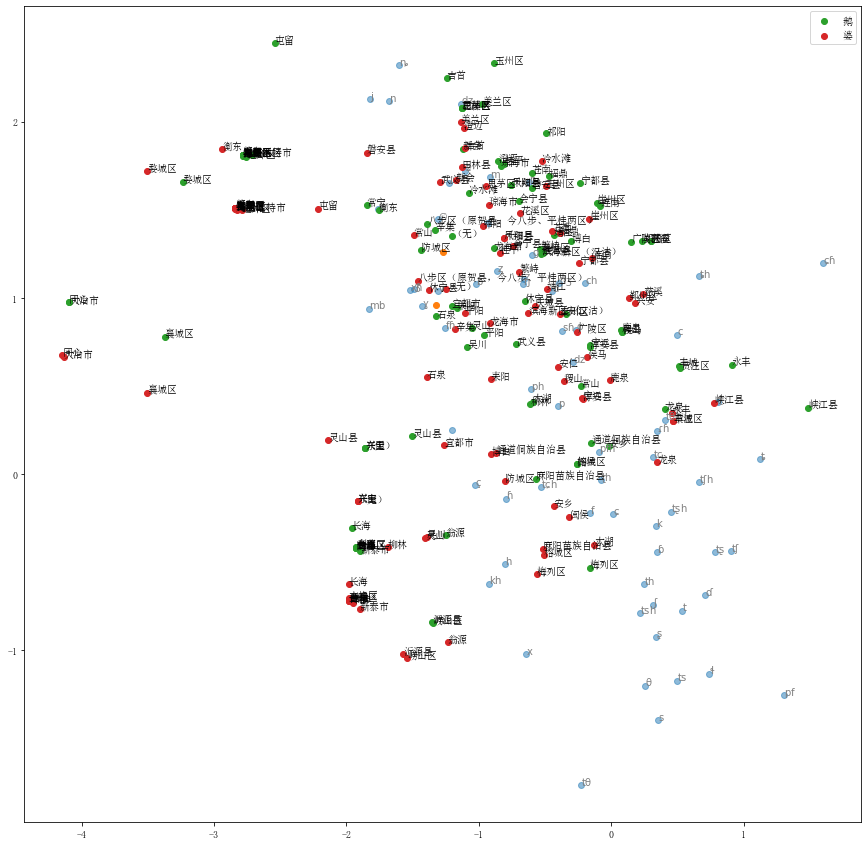

In [46]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:-1], 2, axis=0),
    tf.tile(dp.char_emb[:2], [dp.dialect_emb.shape[0] - 1, 1])
).numpy()
char_pc = char_pca.transform(char_emb)
dest_pc = char_pca.transform(dest_emb).reshape(-1, 2, 2)
dialects = np.char.decode(dp.dialects[:-1].numpy().astype(np.bytes_))
chars = char.loc[dp.chars[:2].numpy().astype(int), 'item'].values

plt.figure(figsize=(15, 15))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')

plt.scatter(char_pc[:2, 0], char_pc[:2, 1])

for i in range(dest_pc.shape[1]):
    plt.scatter(dest_pc[:, i, 0], dest_pc[:, i, 1], label=chars[i])
    for j in range(dialects.shape[0]):
        plt.annotate(location.loc[dialects[j], 'country'], xy=(dest_pc[j, i, 0], dest_pc[j, i, 1]))

plt.legend()
plt.show()

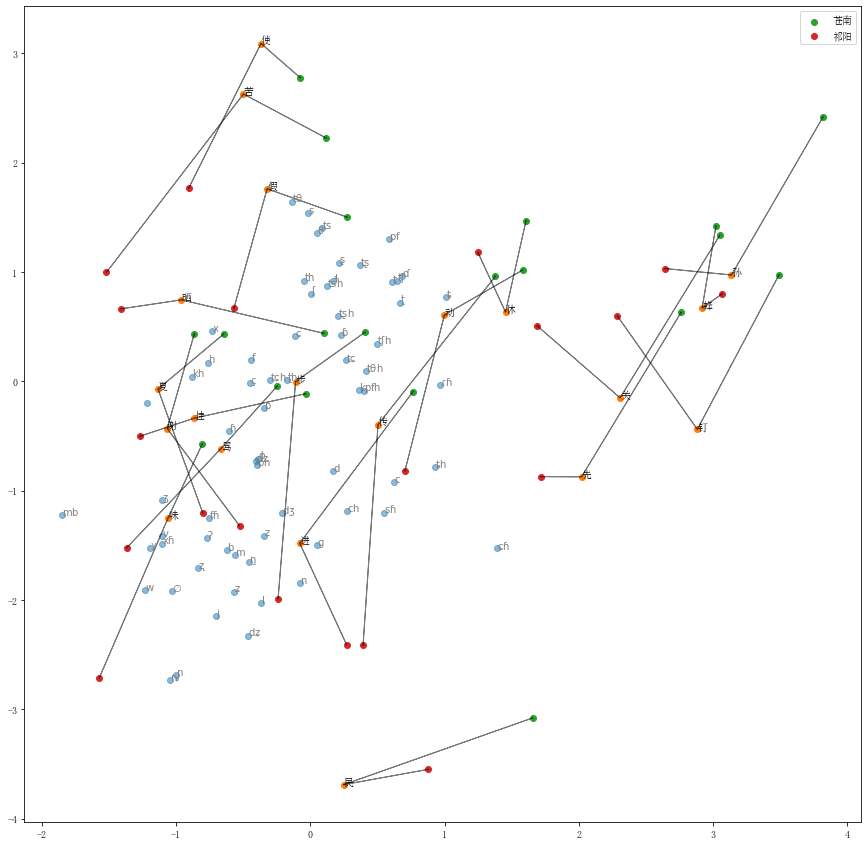

In [22]:
dest_emb = dp.transform(
    tf.repeat(dp.dialect_emb[:2], dp.char_emb.shape[0] - 1, axis=0),
    tf.tile(dp.char_emb[:-1], [2, 1])
).numpy()

dialects = location.loc[np.char.decode(dp.dialects[:2].numpy().astype(np.bytes_)), 'country'].values
idx = np.random.choice(char_emb.shape[0] - 1, 20, replace=False)
char_ids = dp.id_to_char(idx).numpy().astype(np.bytes_).astype(int)
chars = char.loc[char_ids, 'item'].values
char_pc = char_pca.transform(char_emb[idx])
dest_pc = char_pca.transform(dest_emb).reshape([2, -1, 2])[:, idx]

plt.figure(figsize=(15, 15))

plt.scatter(initial_pc[:, 0], initial_pc[:, 1], alpha=0.5)
for i, initial in enumerate(np.char.decode(dp.targets[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]), color='gray')
    
plt.scatter(char_pc[:, 0], char_pc[:, 1])
for i in range(char_pc.shape[0]):
    plt.annotate(chars[i], xy=(char_pc[i, 0], char_pc[i, 1]))

for i in range(dest_pc.shape[0]):
    plt.scatter(dest_pc[i, :, 0], dest_pc[i, :, 1], label=dialects[i])
    
    for j in range(char_pc.shape[0]):
        plt.arrow(char_pc[j, 0], char_pc[j, 1], dest_pc[i, j, 0] - char_pc[j, 0], dest_pc[i, j, 1] - char_pc[j, 1], alpha=0.5)
        
plt.legend()
plt.show()

In [51]:
sample = location.sample(100)

data = []
for id in sample.index:
    d = pd.read_csv(os.path.join(prefix, id + 'mb01dz.csv'), dtype=str)
    d['oid'] = id
    data.append(d)
    
beijing = pd.read_csv(os.path.join(prefix, '03E88mb01dz.csv'), dtype=str)
beijing['oid'] = '03E88'
data.append(beijing)
beijing2 = beijing.copy()
beijing2['oid'] = '03E88_2'
data.append(beijing2)

data = pd.concat(data, ignore_index=True).fillna('')

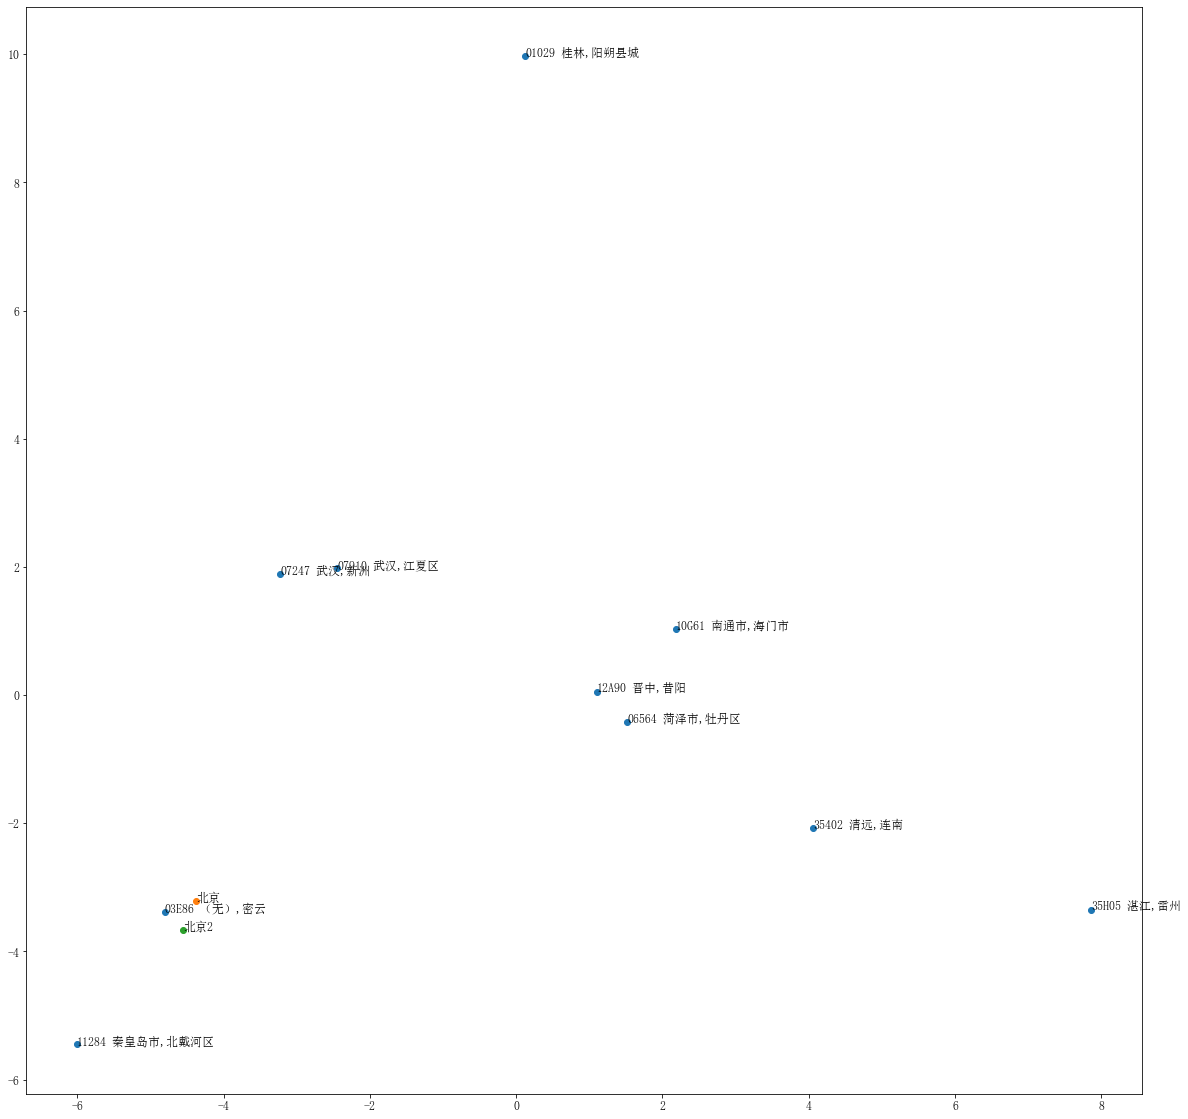

In [52]:
idx = np.random.choice(dialect_pc.shape[0], 10, replace=False)

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(dialect_pc[idx, 0], dialect_pc[idx, 1])
for i in idx:
    try:
        id = dp.dialects[i].numpy().decode()
        plt.annotate(id + ' ' + location.loc[id, 'city'] + ',' + location.loc[id, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))
    except:
        pass

i = dp.dialect_to_id(tf.constant(['03E88']))
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

i = dp.dialect_to_id(tf.constant(['03E88_2']))
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京2', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

plt.show()

In [53]:
dist = np.sqrt(np.sum(np.square(dialect_emb[:-1, None, :] - dialect_emb[None, :-1, :]), axis=2))
idx = np.argsort(dist, axis=1)[:, :10]
display(location.loc[np.char.decode(dp.id_to_dialect(idx[0]).numpy().astype(np.bytes_))])

,longitude,latitude,insertDate,uploader,firstLevelid,sheetName,filepath,province,city,country,...,nation,minorityInfo,dialectInfo,operaInfo,source,degree,area,slice,slices,geometry
26A36,113.341667,26.558333,NaN,NaN,26A36,NaN,湖南/安仁需交文件电子版/模板表/其他/概况.xls,湖南,郴州,安仁,...,汉族占99.8%，其它少数民族占0.1%。,据县民宗局2017年最新数据，全县共有少数民族25个，共计1025人，其中回族15人，佤族4...,全县境内方言主要分以下几种：一种称为“安仁话”，使用人口约35万，按口音又可分为上四里话和下...,（无）,yubao,common,赣语,耒洞,安常小片,POINT (113.34167 26.55833)
02541,117.000000,25.183333,NaN,NaN,02541,NaN,福建/龙岩新罗需交文件电子版/模板表/其他/概况.xls,福建,龙岩,新罗,...,"汉族,50.54万",（无）,新罗区境内有闽南话和客家话两大方言。龙岩话为闽南话，是本地通用的方言，龙岩话以城关话为代表。...,主要是龙岩山歌，按区域来分可划分为龙岩大池山歌、龙岩万安山歌、龙岩白沙山歌、龙岩适中山歌和龙...,yubao,common,NaN,NaN,NaN,POINT (117.00000 25.18333)
08961,120.130000,30.270000,NaN,NaN,08961,NaN,浙江/杭州留下需交文件电子版/模板表/其他/概况.xls,浙江,杭州市,西湖区,...,汉族、蒙古族、回族、藏族、维吾尔族等30多个民族，人口不详。,本区少数民族人口分散居住，家庭内说本族语，对外大都说杭州话或地方普通话。,本区汉语方言分为杭州话、余杭话和闽南话，其中闽南话是方言岛。杭州话属吴语太湖片杭州小片，本区...,本区有用杭州方言说唱的曲艺和地方戏，如杭州小热昏、杭州评话、独脚戏、杭滩、武林调、杭州评词、...,yubao,common,闽语区,闽南片,浙南小片,POINT (120.13000 30.27000)
18941,115.066667,27.833333,NaN,NaN,18941,NaN,江西/新余需交文件电子版/模板表/其他/概况.xls,江西,新余,渝水区,...,汉族64万，少数民族0.3万,无呈区域分布的少数民族语言,新余市渝水区各地方言同属赣方言宜浏片宜春小片，但在语音和词汇等方面存在不同程度的差异，全区可...,主要是花鼓戏，方言多出现在念白部分。当地有另有瞎子戏，由盲人演唱，几乎均用方言，多在街头表演。,yubao,common,赣方言,宜浏片,宜春小片,POINT (115.06667 27.83333)
18E37,114.482723,26.349727,NaN,NaN,18E37,NaN,江西/遂川需交文件电子版/模板表/其他/概况.xls,江西,吉安,遂川,...,汉族占绝大部分，有汉、畲等19个民族，约60.48万人。（2018年县政府网2016年所载）,（无）,本县赣方言主要为赣语吉茶片。境内按“口音”分为城关方言和城关以外的方言，人们通过“口音”大致...,（无）,yubao,common,赣方言,赣语吉茶片,系属不明,POINT (114.48272 26.34973)
02546,118.616667,25.358333,NaN,NaN,02546,NaN,福建/仙游城关需交文件电子版/模板表/其他/概况.xls,福建,莆田,仙游,...,汉族约59.4万人，占99%，回族6000多人，占1%。,（无）,仙游话中的城关话，分布在鲤城街道、鲤南镇、大济镇、龙华镇、度尾镇、赖店镇、榜头镇等各村居，使...,莆仙戏曲，流行于莆仙各地。,yubao,common,NaN,NaN,NaN,POINT (118.61667 25.35833)
11D02,114.133333,38.633333,NaN,NaN,11D02,NaN,河北/阜平需交文件电子版/模板表/其他/概况.xls,河北,保定,阜平,...,绝大多数是汉族，人口约20.49万。少数民族主要是回族、蒙古族，人口约200人，数量极少，且...,（无）,本县分为4种口音。（1）平阳、北庄、台峪三乡镇与曲阳、唐县接壤，语音与曲阳、唐县话相近；（2...,（无）,yubao,common,冀鲁官话,保唐片,涞阜小片,POINT (114.13333 38.63333)
02A15,120.213009,26.941075,NaN,NaN,02A15,NaN,福建/霞浦需交文件电子版/模板表/其他/概况.xls,福建,宁德,霞浦,...,三沙镇境内主要为汉族人口，还有少数畲族。,三沙镇畲族主要分布在东山村、二坑村、单斗村和三坪自然村，使用人口807户，约3000人。,三沙镇的方言主要有三沙闽南话和霞浦话两种，一些与水门乡和牙城镇邻近的村落讲“平阳话”（属于水...,三沙地方曲艺以前有“闽南话讲书”，现已无传人。戏曲以前有业余闽剧团，文革期间停办，文革后恢复...,yubao,common,闽语,闽南话,厦漳泉小片,POINT (120.21301 26.94108)
15978,116.641667,23.391667,NaN,NaN,15978,NaN,广东/金平需交文件电子版/模板表/其他/概况.xls,广东,汕头市,金平区,...,常住人口基本均为汉族，约83万。,（无）,汕头市金平区呈区域分布的方言均属于闽方言闽南方言潮汕片汕头小片，按口音差别，可以分为老市区片...,潮剧，但一般用潮州话表演。中老年人比较感兴趣，年轻人绝大多数不感兴趣。,yubao,common,闽方言,闽南方言,潮汕小片,POINT (116.64167 23.39167)
26509,112.206718,27.457082,NaN,NaN,26509,NaN,湖南/双峰需交文件电子版/模板表/其他/概况.xls,湖南,娄底市,双峰,...,汉族为主,（无）,双峰县辖永丰、梓门桥、走马街、洪山殿、蛇形山、杏子铺、井字、荷叶、甘棠、三塘铺、青树坪、锁石...,无本地戏曲，主要戏曲是花鼓戏，使用的方言是长沙话。有用本县方言的山歌和船歌。,yubao,common,NaN,NaN,NaN,POINT (112.20672 27.45708)


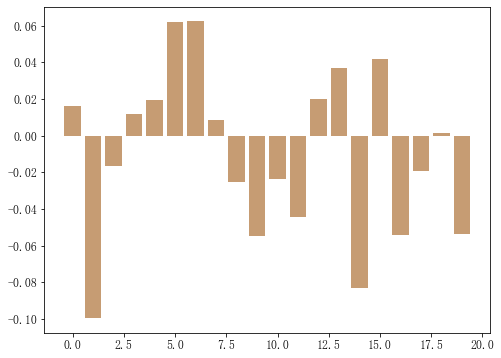

In [102]:
emb = dp.get_dialect_emb(tf.convert_to_tensor(['08K12', '02G36']))
beijing_emb = emb[0]
beijing2_emb = emb[1]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(emb_size), beijing_emb, alpha=0.5)
plt.bar(np.arange(emb_size), beijing2_emb, alpha=0.5)
plt.show()

In [103]:
sample_data = data.sample(10000)
sample_dialects = sample_data['oid'].values
sample_chars = sample_data['iid'].values
preds = np.char.decode(dp.predict(sample_data[['oid', 'iid']].values).numpy().astype(np.bytes_))
sample_emb = dp.transform(dp.get_dialect_emb(sample_dialects), dp.get_char_emb(sample_chars))
pca = PCA(2)
sample_pc = pca.fit_transform(sample_emb)

initial_emb = dp.output_embs[0].numpy()
final_emb = dp.output_embs[1].numpy()
tone_emb = dp.output_embs[2].numpy()

initial_pc = pca.transform(initial_emb)
final_pc = pca.transform(final_emb)
tone_pc = pca.transform(tone_emb)

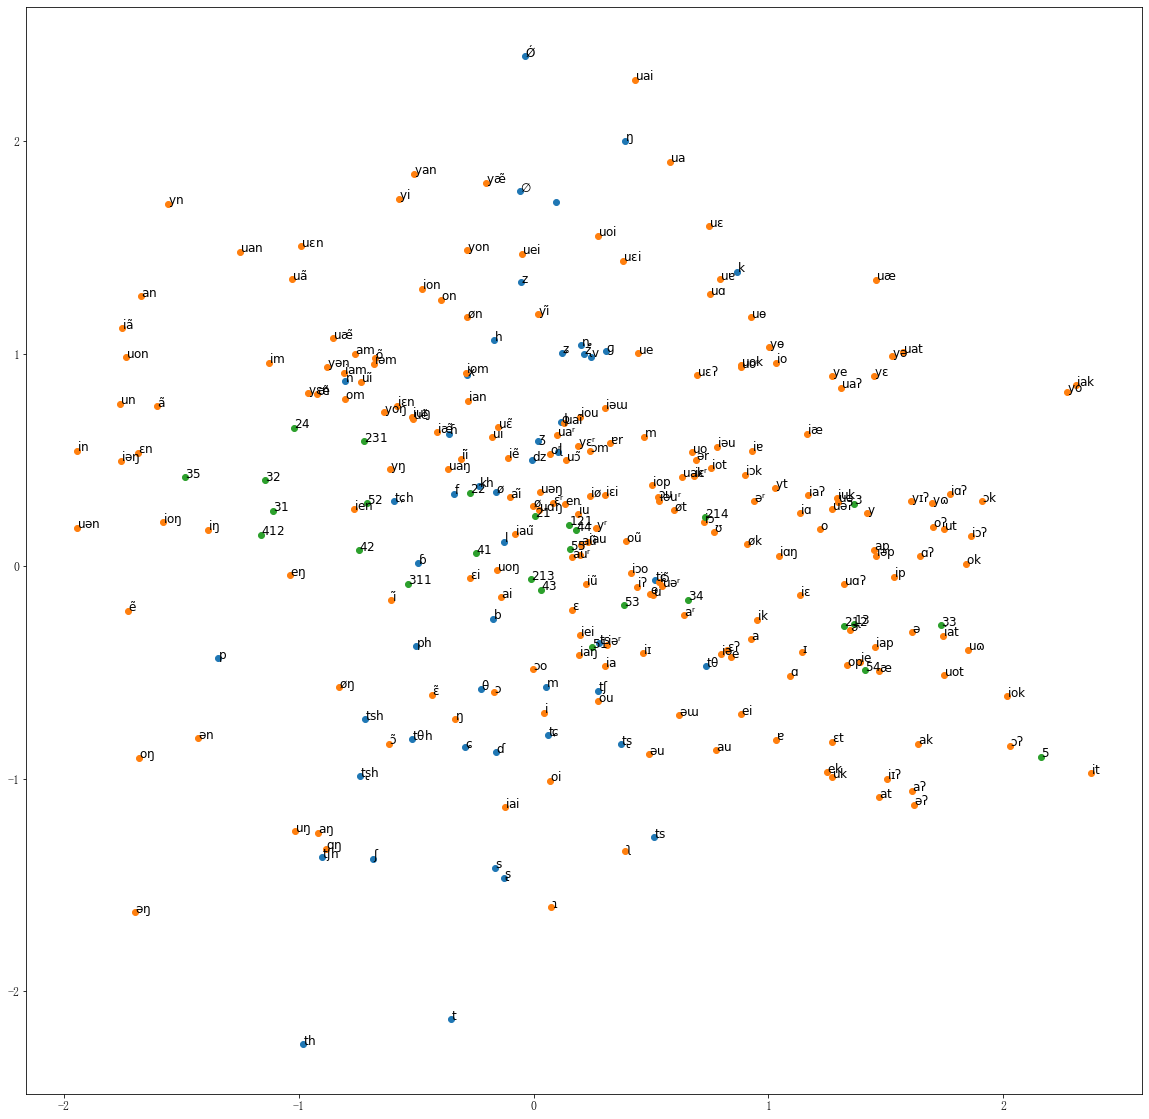

In [104]:
plt.figure(figsize=(20, 20))

if False:
    for initial in np.unique(preds[:, 0]):
        cooc = np.mean(sample_pc[preds[:, 0] == initial], axis=0)
        plt.scatter(cooc[None, 0], cooc[None, 1], color='red')
        plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(cooc[0], cooc[1]))
    
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(np.char.decode(dp.outputs[0].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
plt.scatter(final_pc[:, 0], final_pc[:, 1])
for i, final in enumerate(np.char.decode(dp.outputs[1].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(final), xy=(final_pc[i, 0], final_pc[i, 1]))
    
plt.scatter(tone_pc[:, 0], tone_pc[:, 1])
for i, tone in enumerate(np.char.decode(dp.outputs[2].numpy().astype(np.bytes_))):
    plt.annotate(r'$\mathrm{{{}}}$'.format(tone), xy=(tone_pc[i, 0], tone_pc[i, 1]))
    
plt.show()

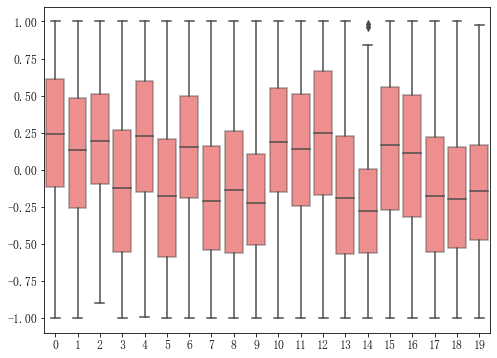

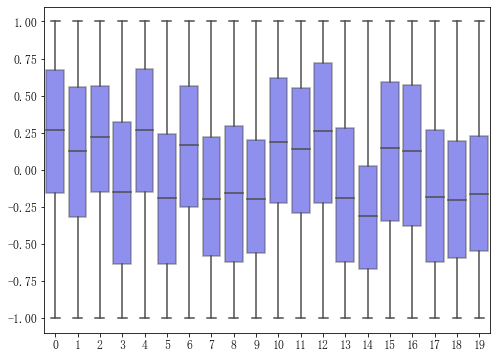

In [105]:
char_emb = tf.clip_by_value(dp.char_emb, -1, 1).numpy()

plt.figure(figsize=(8, 6))
sns.boxplot(data=char_emb, color='red', boxprops={'alpha': 0.5})
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(data=sample_emb, color='blue', boxprops={'alpha': 0.5})
plt.show()

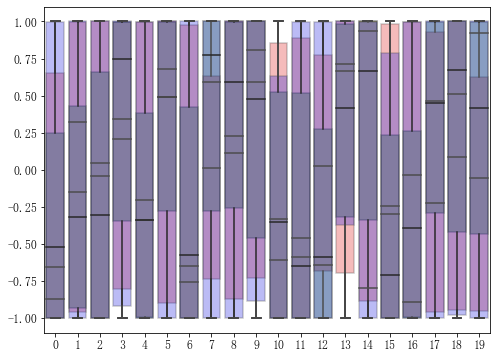

In [106]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=initial_emb, color='red', boxprops={'alpha': 0.3})
sns.boxplot(data=final_emb, color='green', boxprops={'alpha': 0.3})
sns.boxplot(data=tone_emb, color='blue', boxprops={'alpha': 0.3})
plt.show()

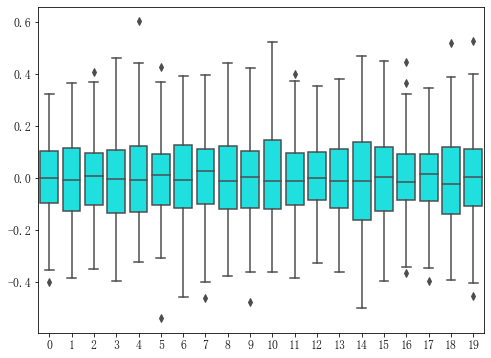

In [107]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dp.res_weights2[0].numpy(), color='cyan')
plt.show()

In [108]:
pred = pd.DataFrame(
    np.char.decode(tf.stack(
        [dp.id_to_target(i, tf.argmax(
            tf.matmul(char_emb[:-1], e, transpose_b=True),
            axis=1
        )) for i, e in enumerate(dp.output_embs)],
        axis=1
    ).numpy().astype(np.bytes_)),
    index=dp.chars.numpy().astype(int),
    columns=['initial', 'final', 'tone']
)
display(pd.concat([pred, char['item']], axis=1))

,initial,final,tone,item
1,t,uə,213,多
2,th,uə,213,拖
3,t,a,55,大
4,l,ɔ,35,锣
5,ts,o,55,左
...,...,...,...,...
996,l,u,33,褥
997,tɕh,y,5,曲
998,tɕ,y,5,局
999,Ǿ,y,33,玉


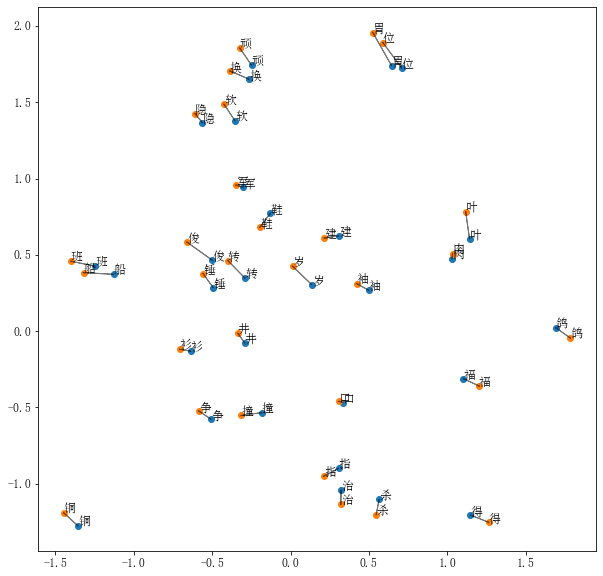

In [109]:
# char_emb = tf.linalg.normalize(dp.char_emb, axis=1)[0].numpy()
# dest_emb = tf.linalg.normalize(dp.transform(tf.tile(dp.get_dialect_emb(tf.convert_to_tensor(['24J23'])), [char_emb.shape[0], 1]), char_emb), axis=1)[0].numpy()
char_emb = tf.clip_by_value(dp.char_emb, -1, 1).numpy()
dest_emb = dp.transform(tf.tile(dp.get_dialect_emb(['24J23']), [char_emb.shape[0], 1]), char_emb).numpy()
char_pca = PCA(2).fit(char_emb)

idx = np.random.choice(char_emb.shape[0] - 1, 30, replace=False)
char_ids = dp.id_to_char(idx).numpy().astype(np.bytes_).astype(int)
chars = char.loc[char_ids, 'item'].values
char_pc = char_pca.transform(char_emb[idx])
dest_pc = char_pca.transform(dest_emb[idx])

plt.figure(figsize=(10, 10))

plt.scatter(char_pc[:, 0], char_pc[:, 1])    
plt.scatter(dest_pc[:, 0], dest_pc[:, 1])
for i in range(char_pc.shape[0]):
    plt.arrow(char_pc[i, 0], char_pc[i, 1], dest_pc[i, 0] - char_pc[i, 0], dest_pc[i, 1] - char_pc[i, 1], alpha=0.5)
    plt.annotate(chars[i], xy=(char_pc[i, 0], char_pc[i, 1]))
    plt.annotate(chars[i], xy=(dest_pc[i, 0], dest_pc[i, 1]))
        
plt.show()

In [110]:
dist = np.sqrt(np.sum(np.square(char_emb[:-1, None, :] - char_emb[None, :-1, :]), axis=2))
idx = np.argsort(dist, axis=1)[:, :10]
display(char.loc[dp.id_to_char(idx[0]).numpy().astype(int)])

,item,memo
cid,,
1,多,NaN
17,躲,NaN
280,刀,NaN
6,歌,NaN
574,夺,NaN
557,端,～午
5,左,NaN
372,丢,NaN
2,拖,NaN


In [111]:
cemb = dp.get_char_emb(['0280', '0282', '0917', '0923'])
new_cemb = cemb[0] - cemb[1] + cemb[3]
idx = np.argsort(np.sum(np.square(char_emb[:-1] - new_cemb), axis=1))[:10]
display(char.loc[dp.id_to_char(idx).numpy().astype(int)])

,item,memo
cid,,
943,冬,～至
917,东,NaN
918,懂,NaN
919,冻,NaN
925,洞,NaN
794,灯,NaN
953,中,当～
707,党,NaN
924,动,NaN


In [112]:
test_dialects = ['25589', '15J11']
test_chars = ['0469', '0474', '0656']
demb = dp.get_dialect_emb(test_dialects)
cemb = dp.get_char_emb(test_chars)
emb = dp.transform(tf.repeat(demb, cemb.shape[0], axis=0), tf.tile(cemb, [demb.shape[0], 1]))
new_emb = emb[0::3] - emb[1::3] + emb[2::3]
pred = np.char.decode(tf.stack(
    [dp.id_to_target(i, tf.argmax(tf.matmul(new_emb, e, transpose_b=True), axis=1)) for i, e in enumerate(dp.output_embs)]
    , axis=1
).numpy().astype(np.bytes_))
display(pred)

array([['k', 'iə', '5'],
       ['k', 'iə', '5']], dtype='<U2')

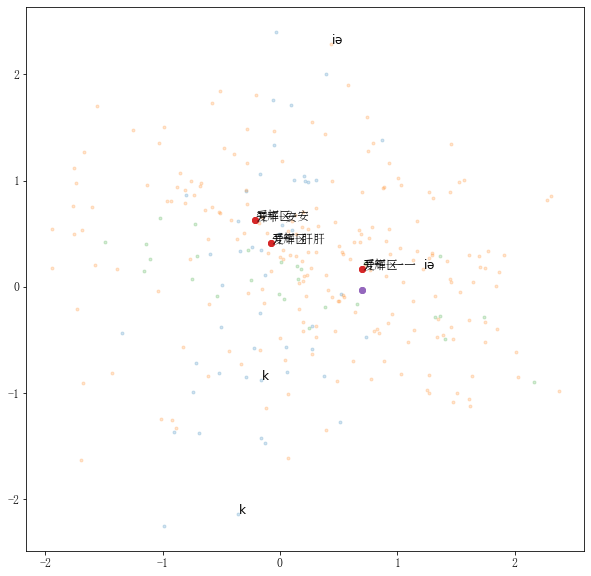

In [113]:
plt.figure(figsize=(10, 10))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1], marker='.', alpha=0.2)
plt.scatter(final_pc[:, 0], final_pc[:, 1], marker='.', alpha=0.2)
plt.scatter(tone_pc[:, 0], tone_pc[:, 1], marker='.', alpha=0.2)
pc = pca.transform(tf.linalg.normalize(emb, axis=1)[0])
new_pc = pca.transform(tf.linalg.normalize(new_emb, axis=1)[0])
plt.scatter(pc[:, 0], pc[:, 1])
plt.scatter(new_pc[:, 0], new_pc[:, 1])

for i in range(pc.shape[0]):
    plt.annotate(
        '{}-{}'.format(location.loc[test_dialects[i // 3], 'country'], char.loc[int(test_chars[i % 3]), 'item']),
        xy=(pc[i, 0], pc[i, 1])
    )
    
initial_id = dp.target_to_id(0, pred[:, 0]).numpy()
for i in range(initial_id.shape[0]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(pred[i, 0]), xy=(initial_pc[i, 0], initial_pc[i, 1]))
    
final_id = dp.target_to_id(1, pred[:, 1]).numpy()
for i in range(final_id.shape[0]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(pred[i, 1]), xy=(final_pc[i, 0], final_pc[i, 1]))
    
plt.show()

In [116]:
demb = dp.get_dialect_emb(['16C06', '18E27'])
demb1 = demb[0]
demb2 = demb[1]
cemb = dp.get_char_emb(['0843'])[0]
w = np.arange(0, 1.1, 0.1)
demb = (1 - w[:, None]) * demb1[None, :] + w[:, None] * demb2[None, :]
emb = dp.transform(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
pred = dp.predict_id_emb(demb, tf.tile(cemb[None, :], [demb.shape[0], 1]))
display(np.char.decode(tf.stack([dp.id_to_target(i, pred[:, i]) for i in range(pred.shape[1])], axis=1).numpy().astype(np.bytes_)))

array([['p', 'æ', '33'],
       ['p', 'æ', '33'],
       ['p', 'æ', '33'],
       ['p', 'ə', '33'],
       ['p', 'ə', '33'],
       ['p', 'ə', '33'],
       ['p', 'ə', '44'],
       ['p', 'ə', '44'],
       ['p', 'ə', '44'],
       ['p', 'ə', '44'],
       ['p', 'ə', '44']], dtype='<U2')

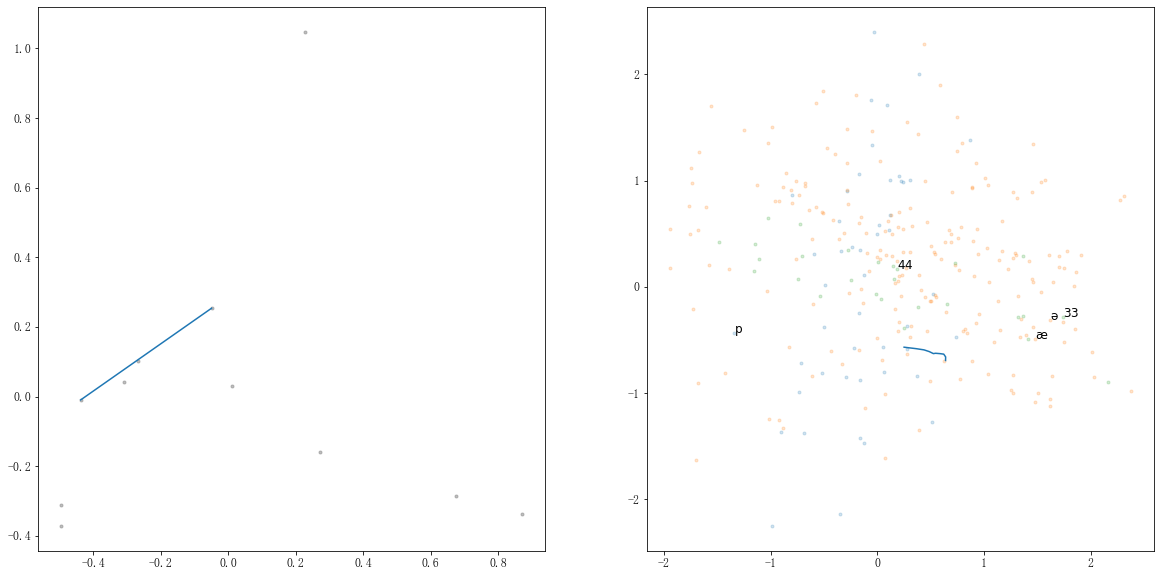

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

ax1.scatter(dialect_pc[:, 0], dialect_pc[:, 1], marker='.', color='gray', alpha=0.5)
src_pc = dialect_pca.transform(demb.numpy())
ax1.plot(src_pc[:, 0], src_pc[:, 1])

ax2.scatter(initial_pc[:, 0], initial_pc[:, 1], marker='.', alpha=0.2)
ax2.scatter(final_pc[:, 0], final_pc[:, 1], marker='.', alpha=0.2)
ax2.scatter(tone_pc[:, 0], tone_pc[:, 1], marker='.', alpha=0.2)
# dest_pc = pca.transform(tf.math.l2_normalize(emb, axis=1).numpy())
dest_pc = pca.transform(emb)
ax2.plot(dest_pc[:, 0], dest_pc[:, 1])

for i, pc in enumerate([initial_pc, final_pc, tone_pc]):
    ids = tf.unique(pred[:, i])[0]
    phones = np.char.decode(dp.id_to_target(i, ids).numpy().astype(np.bytes_))
    for id, phone in zip(ids.numpy(), phones):
        ax2.annotate(r'$\mathrm{{{}}}$'.format(phone), xy=(pc[id, 0], pc[id, 1]))
    
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

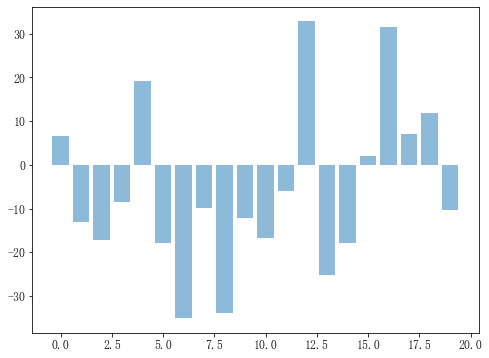

In [61]:
plt.figure(figsize=(8, 6))
plt.bar(np.arange(emb_size), emb[0], alpha=0.5)
plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(dp.output_embs[0]), dp.target_to_id(0, tf.convert_to_tensor(['p'])))[0], alpha=0.5)
plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(dp.output_embs[1]), dp.target_to_id(1, tf.convert_to_tensor(['ai'])))[0], alpha=0.5)
# plt.bar(np.arange(emb_size), tf.nn.embedding_lookup(tf.transpose(dp.output_embs[2]), dp.target_to_id(2, tf.convert_to_tensor(['35'])))[0], alpha=0.5)
plt.show()

In [340]:
def make_model(dialect_num, char_num, output_shapes, dialect_emb_size=20, char_emb_size=20):
    dialect_id = tf.keras.Input(shape=(), name='dialect_id')
    char_id = tf.keras.Input(shape=(), name='char_id')
    dialect_emb = tf.keras.layers.Embedding(
        dialect_num,
        dialect_emb_size,
        embeddings_regularizer=tf.keras.regularizers.l2(),
        name='dialect_emb', 
    )(dialect_id)
    char_emb = tf.keras.layers.Embedding(
        char_num,
        char_emb_size,
        embeddings_regularizer=tf.keras.regularizers.l2(),
        name='char_emb'
    )(char_id)
    x = tf.keras.layers.Concatenate()([dialect_emb, char_emb])
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    preds = []
    for shape in output_shapes:
        preds.append(tf.keras.layers.Dense(shape, activation='softmax')(x))
        
    model = tf.keras.Model([dialect_id, char_id], preds, name='encoder')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
oe = OrdinalEncoder(dtype=np.int32)
codes = oe.fit_transform(data[['oid', 'iid', 'initial', 'finals', 'tone']])

In [344]:
train_data, test_data = train_test_split(codes, test_size=0.1)

In [347]:
model = make_model(
    oe.categories_[0].shape[0],
    oe.categories_[1].shape[0],
    [oe.categories_[2].shape[0], oe.categories_[3].shape[0], oe.categories_[4].shape[0]],
    dialect_emb_size=20,
    char_emb_size=20
)
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dialect_id (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
char_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
dialect_emb (Embedding)         (None, 20)           2040        dialect_id[0][0]                 
__________________________________________________________________________________________________
char_emb (Embedding)            (None, 20)           20000       char_id[0][0]                    
____________________________________________________________________________________________

In [359]:
model.fit(
    [train_data[:, 0], train_data[:, 1]],
    [train_data[:, 2], train_data[:, 3], train_data[:, 4]],
    epochs=20,
    batch_size=100
)

Epoch 1/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7210 - dense_92_loss: 0.3936 - dense_93_loss: 0.7019 - dense_94_loss: 0.3114 - dense_92_accuracy: 0.8777 - dense_93_accuracy: 0.7918 - dense_94_accuracy: 0.9121
Epoch 2/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7133 - dense_92_loss: 0.3906 - dense_93_loss: 0.6992 - dense_94_loss: 0.3105 - dense_92_accuracy: 0.8762 - dense_93_accuracy: 0.7910 - dense_94_accuracy: 0.9136A: 1s - loss: 1.6963 - dense_92_loss: 0.3857 - dense_93_loss: 0.6875 - dense_94_loss: 0.3096 - dense_92_accuracy: 0.8773 - dense_93_accuracy: 0.7931 - dense_94_accuracy: 0.9 - ETA: 1s - loss: 1.7004 - dense_92_loss: 0.3860 - dense_93_loss: 0.6910 - dense_94_loss: 0.3100 - dense_92_accuracy: 0.8772 - dense_93_accuracy: 0.7924 - den
Epoch 3/20
961/961 [==============================] - 3s 3ms/step - loss: 1.7000 - dense_92_loss: 0.3904 - dense_93_loss: 0.6897 - dense_94_loss: 0.3075 - dense_92_accuracy: 0.8770 - dense_93_ac

In [360]:
model.evaluate(
    [test_data[:, 0], test_data[:, 1]],
    [test_data[:, 2], test_data[:, 3], test_data[:, 4]]
)

334/334 [==============================] - 1s 1ms/step - loss: 1.7732 - dense_92_loss: 0.4004 - dense_93_loss: 0.7494 - dense_94_loss: 0.3212 - dense_92_accuracy: 0.8772 - dense_93_accuracy: 0.7873 - dense_94_accuracy: 0.9112A: 0s - loss: 1.7613 - dense_92_loss: 0.4018 - dense_93_loss: 0.7398 - dense_94_loss: 0.3174 - dense_92_accuracy: 0.8789 - dense_93_accuracy: 0.7866 - dense_94_accuracy: 0


[1.773205041885376,
 0.40044912695884705,
 0.7493739724159241,
 0.3211662471294403,
 0.8772143721580505,
 0.787327766418457,
 0.9112381935119629]

In [361]:
dialect_emb = model.get_layer('dialect_emb').get_weights()[0]
dialect_pc = PCA(2).fit_transform(dialect_emb)

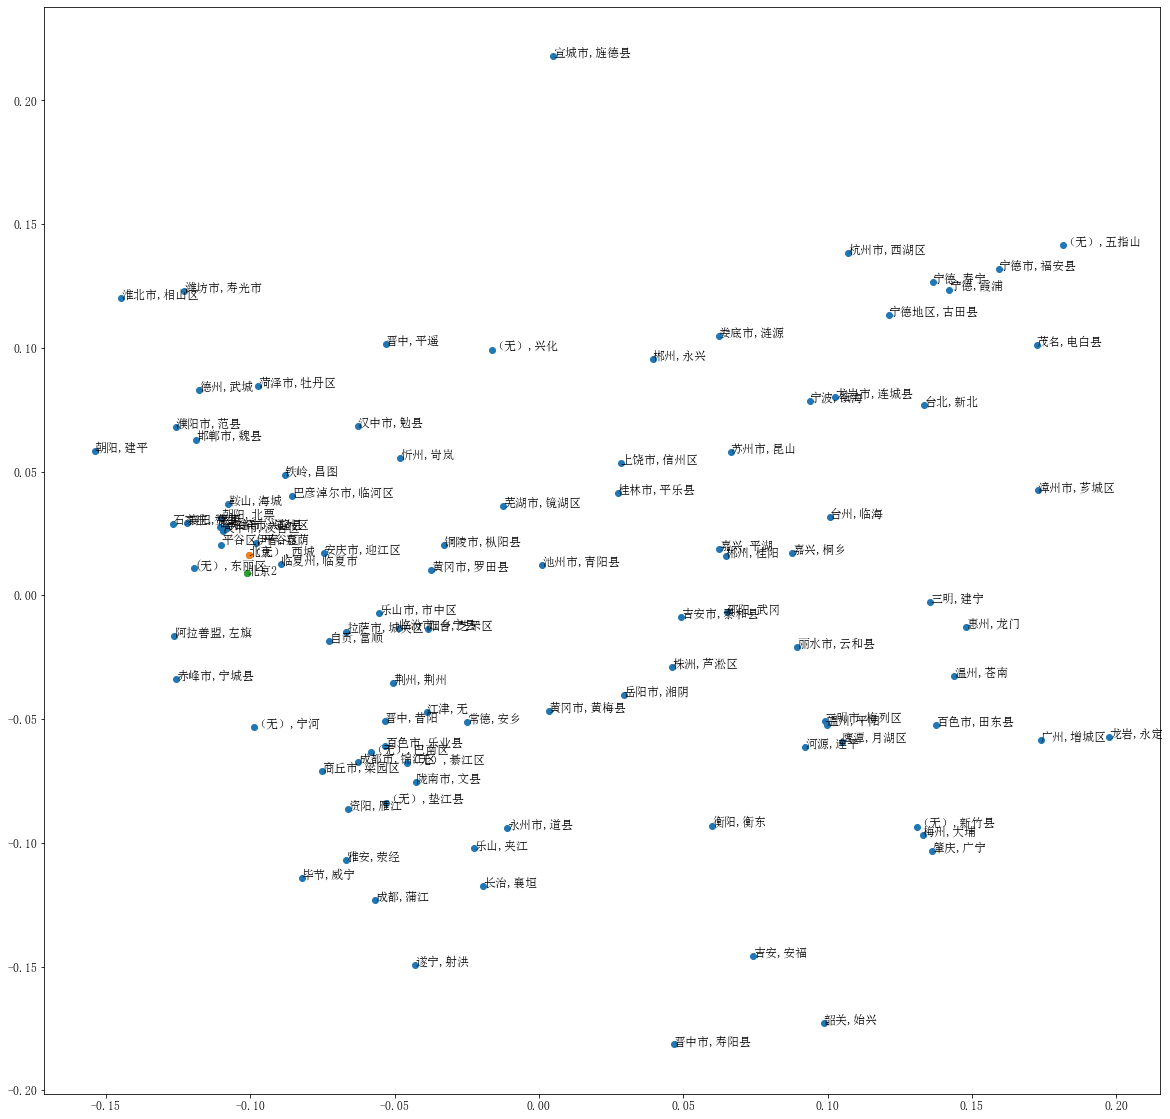

In [362]:
# idx = np.random.choice(dialect_pc.shape[0], 200, replace=False)
idx = np.arange(dialect_pc.shape[0])

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(dialect_pc[idx, 0], dialect_pc[idx, 1])
for i in idx:
    id = oe.categories_[0][i]
    try:
        plt.annotate(location.loc[id, 'city'] + ',' + location.loc[id, 'country'], xy=(dialect_pc[i, 0], dialect_pc[i, 1]))
    except:
        pass
    
i = np.argwhere(oe.categories_[0] == '03E88')[0]
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

i = np.argwhere(oe.categories_[0] == '03E88_2')[0]
plt.scatter(dialect_pc[i, 0], dialect_pc[i, 1])
plt.annotate('北京2', xy=(dialect_pc[i[0], 0], dialect_pc[i[0], 1]))

plt.show()

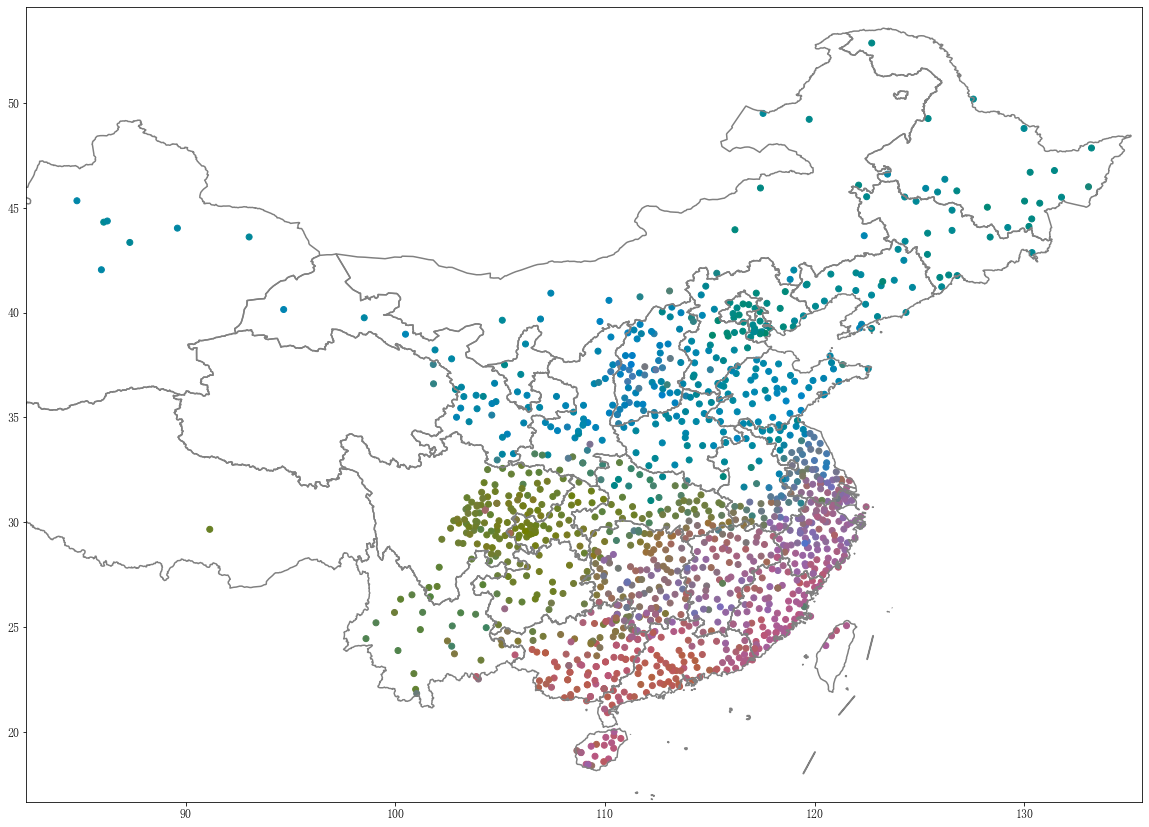

In [217]:
similarity.plot_map(china, location.loc[oe.categories_[0]], pc=dialect_pc, figsize=(20, 20))
plt.show()

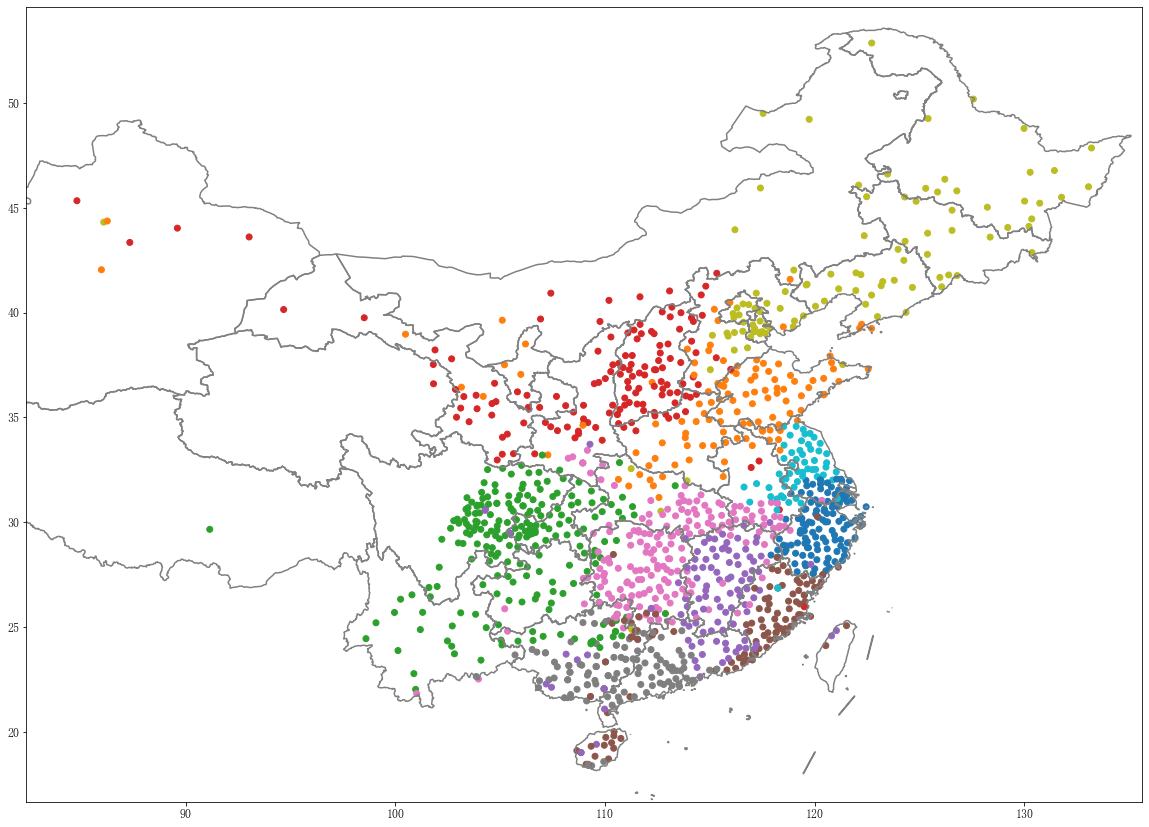

In [216]:
labels = KMeans(n_clusters=10).fit_predict(dialect_emb)
similarity.plot_map(china, location.loc[oe.categories_[0]], column=labels, figsize=(20, 20), cmap='tab10')
plt.show()

In [219]:
labels = SpectralClustering(n_clusters=10).fit_predict(dialect_emb)
similarity.plot_map(china, location.loc[oe.categories_[0]], column=labels, figsize=(20, 20), cmap='tab10')
plt.show()

KeyboardInterrupt: 

In [220]:
char_emb = model.get_layer('char_emb').get_weights()[0]
char_pc = PCA(2).fit_transform(char_emb)

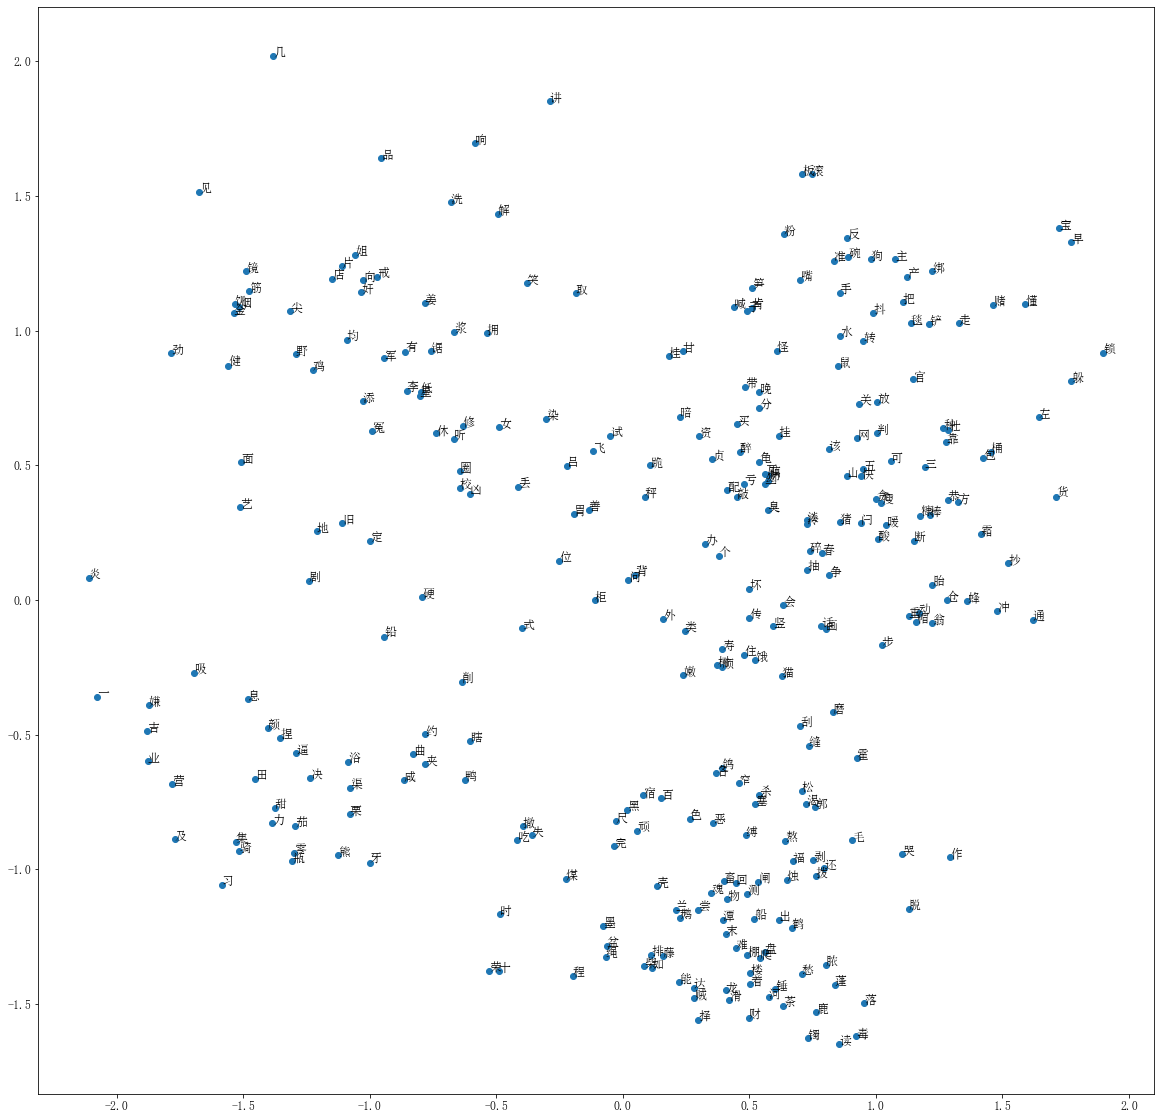

In [222]:
idx = np.random.choice(char_pc.shape[0], 300, replace=False)

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(char_pc[idx, 0], char_pc[idx, 1])
for i in idx:
    try:
        plt.annotate(char.loc[int(oe.categories_[1][i]), 'item'], xy=(char_pc[i, 0], char_pc[i, 1]))
    except:
        pass
plt.show()

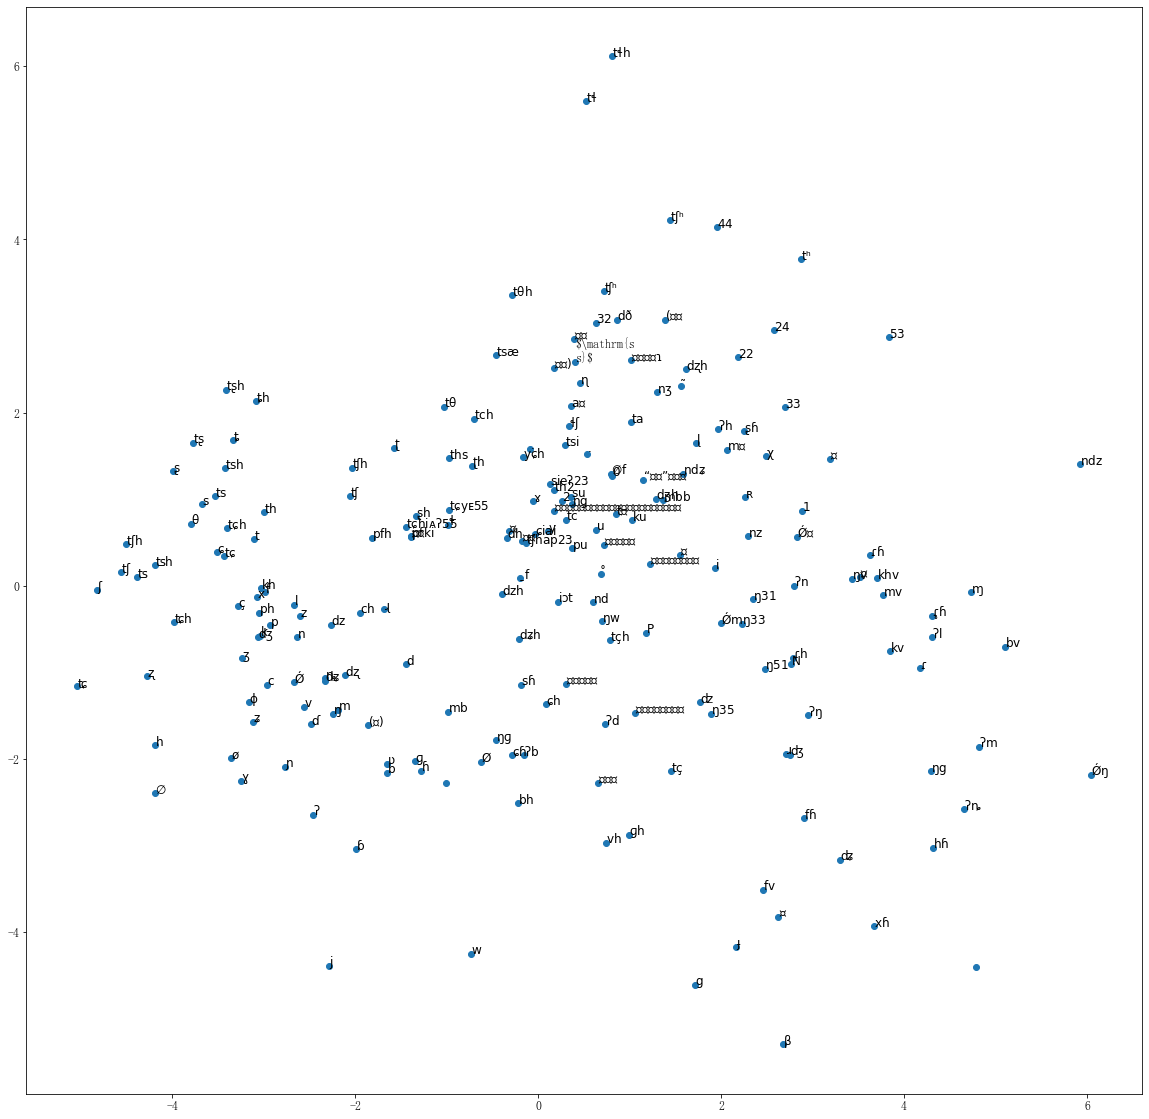

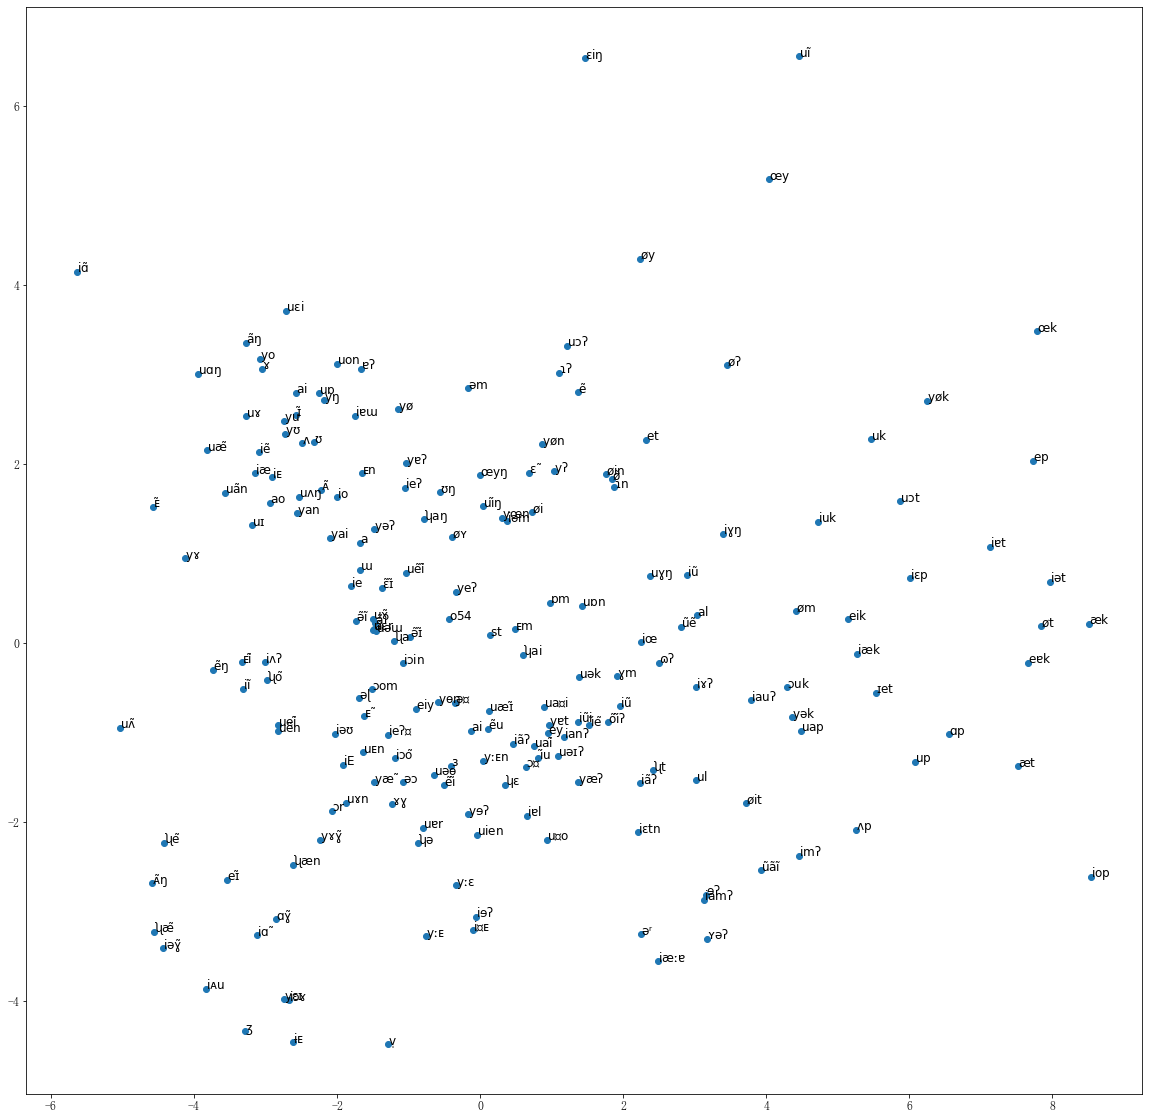

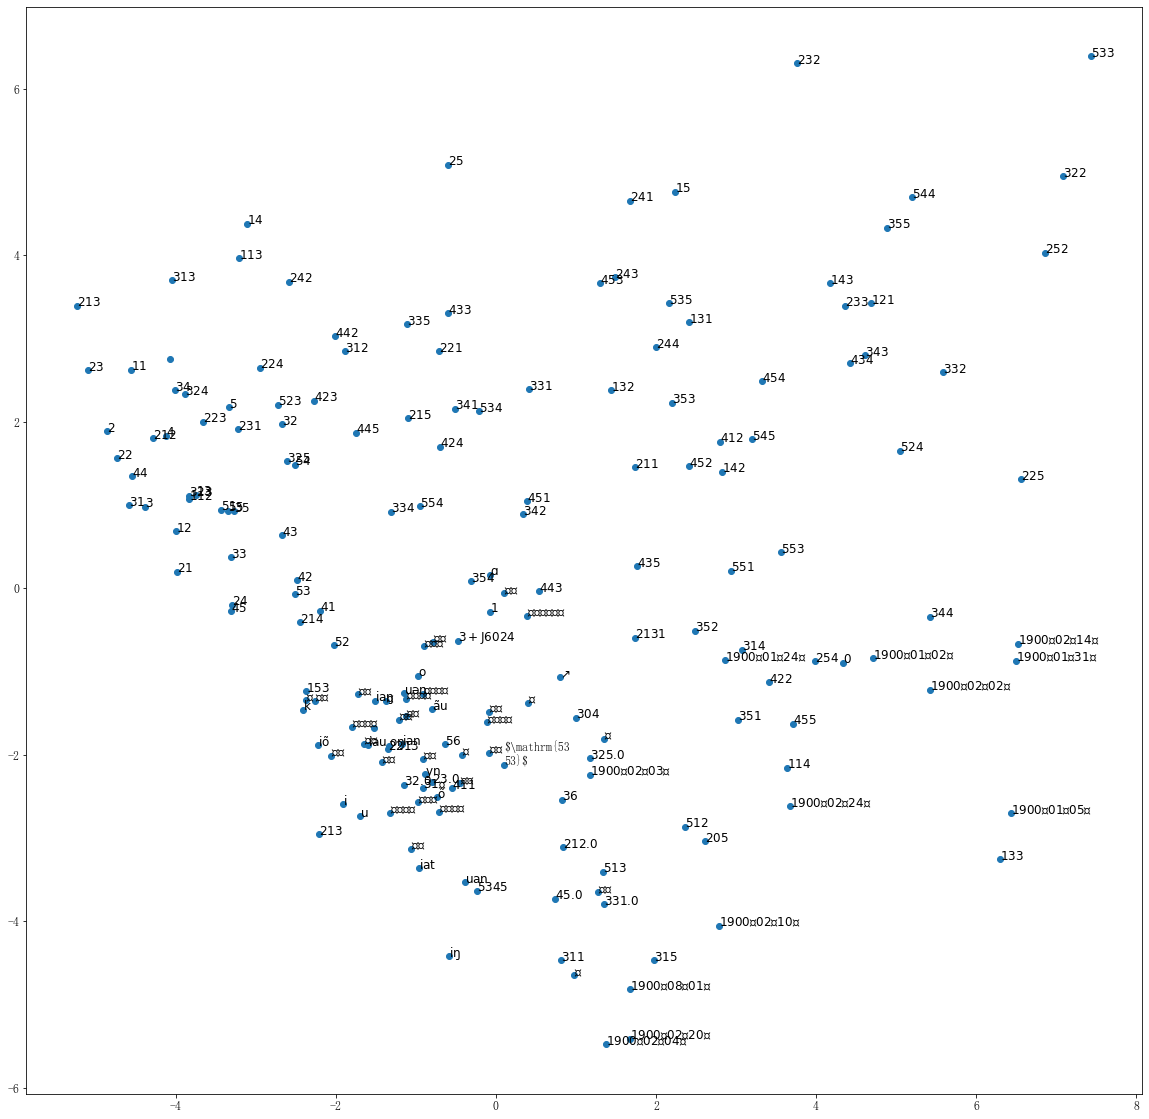

In [243]:
initial_emb = model.get_layer('dense_67').get_weights()[0].T
final_emb = model.get_layer('dense_68').get_weights()[0].T
tone_emb = model.get_layer('dense_69').get_weights()[0].T

initial_pc = PCA(2).fit_transform(initial_emb)
final_pc = PCA(2).fit_transform(final_emb)
tone_pc = PCA(2).fit_transform(tone_emb)

plt.rcParams['font.size'] = 12

plt.figure(figsize=(20, 20))
plt.scatter(initial_pc[:, 0], initial_pc[:, 1])
for i, initial in enumerate(oe.categories_[2]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(initial), xy=(initial_pc[i, 0], initial_pc[i, 1]))
plt.show()

idx = np.random.choice(oe.categories_[3].shape[0], 200, replace=False)

plt.figure(figsize=(20, 20))
plt.scatter(final_pc[idx, 0], final_pc[idx, 1])
for i in idx:
    plt.annotate(r'$\mathrm{{{}}}$'.format(oe.categories_[3][i]), xy=(final_pc[i, 0], final_pc[i, 1]))
plt.show()

plt.figure(figsize=(20, 20))
plt.scatter(tone_pc[:, 0], tone_pc[:, 1])
for i, tone in enumerate(oe.categories_[4]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(tone), xy=(tone_pc[i, 0], tone_pc[i, 1]))
plt.show()

In [273]:
beijing_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88')[0, 0]]
changping_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E82')[0, 0]]
harbin_emb = dialect_emb[np.argwhere(oe.categories_[0] == '25381')[0, 0]]
guangzhou_emb = dialect_emb[np.argwhere(oe.categories_[0] == '15231')[0, 0]]
wuzhou_emb = dialect_emb[np.argwhere(oe.categories_[0] == '01G27')[0, 0]]

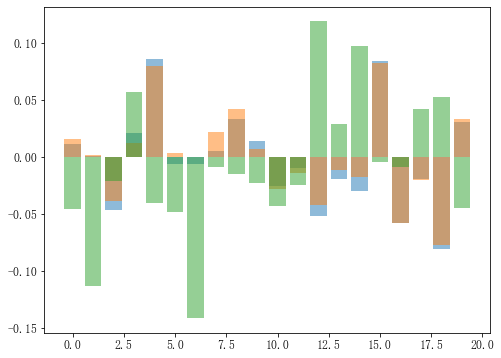

In [367]:
beijing_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88')[0, 0]]
beijing2_emb = dialect_emb[np.argwhere(oe.categories_[0] == '03E88_2')[0, 0]]
zengcheng_emb = dialect_emb[np.argwhere(oe.categories_[0] == '15237')[0, 0]]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(beijing_emb.shape[0]), beijing_emb, alpha=0.5)
plt.bar(np.arange(beijing2_emb.shape[0]), beijing2_emb, alpha=0.5)
plt.bar(np.arange(zengcheng_emb.shape[0]), zengcheng_emb, alpha=0.5)
plt.show()